# Recurrent Inference Machines
In this notebook, I will develop the framework to use a recurrent inference machine to solve a basic 1D deconvolution problem.

The problem: Given a 1D Gaussian profile convolved with Poisson noise, can we use and RIM to recover the original 1D Gaussian profile.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time
import sys
sys.path.append("/home/carterrhea/Documents/astroRIM/")  # Full path to AstroRIM module 
from RIM_sequence import RIM
from RIM_model import RIM_Model_2D  # Import name  of architecture to use
from RIM_physical import calc_grad_standard_2D  # Import name of gradient log likelihood
plt.style.use('dark.mplstyle')


2022-11-15 11:51:23.791505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 11:51:24.963748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 11:51:24.964590: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
n = 10  # Size of spectrum
N = 2000  # Number of spectra

## Create Convolved Image

In [3]:
def gaussian2D(A, x, y, mux, muy, sigx, sigy):
    x_term = (x-mux)**2/ (2 *sigx**2.)
    y_term = (y-muy)**2/ (2 *sigy**2.)
    return A*np.exp(-(x_term+y_term))

def conv_mat(n):
    """
    Create convolution matrix that is an identity matrix with noise
    """
    conv_mat = np.eye(n)+np.random.normal(0, 0.05, (n,n))
    return conv_mat

def create_convolved(N):
    '''
    Create convolved Gaussian that are 28x28
    Args:
     n - number of Gausians
    Return:
     gaussians - List of convolved Gaussians
    '''
    gaussians_initial = []  # List of initial Gaussians
    powerlaw_conv = []  # List of Powerlaws used in convolution
    gaussians_final = []  # List of final Gaussians after convolution
    noise = []  # List of noises added
    for i in range(N):
        # Create original 2D Gaussian 
        x = np.linspace(-10,10,n)
        y = np.linspace(-10,10,n)
        x, y = np.meshgrid(x, y)
        mux = np.random.uniform(0.001,.01)
        muy = np.random.uniform(0.001,.01)
        sigx = np.random.uniform(3,5)
        sigy = np.random.uniform(3,5)
        gaus_orig = gaussian2D(1, x, y, mux, muy, sigx, sigy)
        gaussians_initial.append(gaus_orig)
        # Convolve with additional Gaussian
        conv_mat_ = conv_mat(n)
        gaus_conv = conv_mat_@gaus_orig
        # Add noise
        noise_ = np.random.normal(0,0.1, (n, n))
        gaus_noise = gaus_conv + noise_
        gaussians_final.append(gaus_noise)
        powerlaw_conv.append(conv_mat_)
        noise.append(noise_)

    return gaussians_initial,gaussians_final,powerlaw_conv,noise

# Create N instances
gaussians_initial, gaussians_final,powerlaw_conv,noise = create_convolved(N)


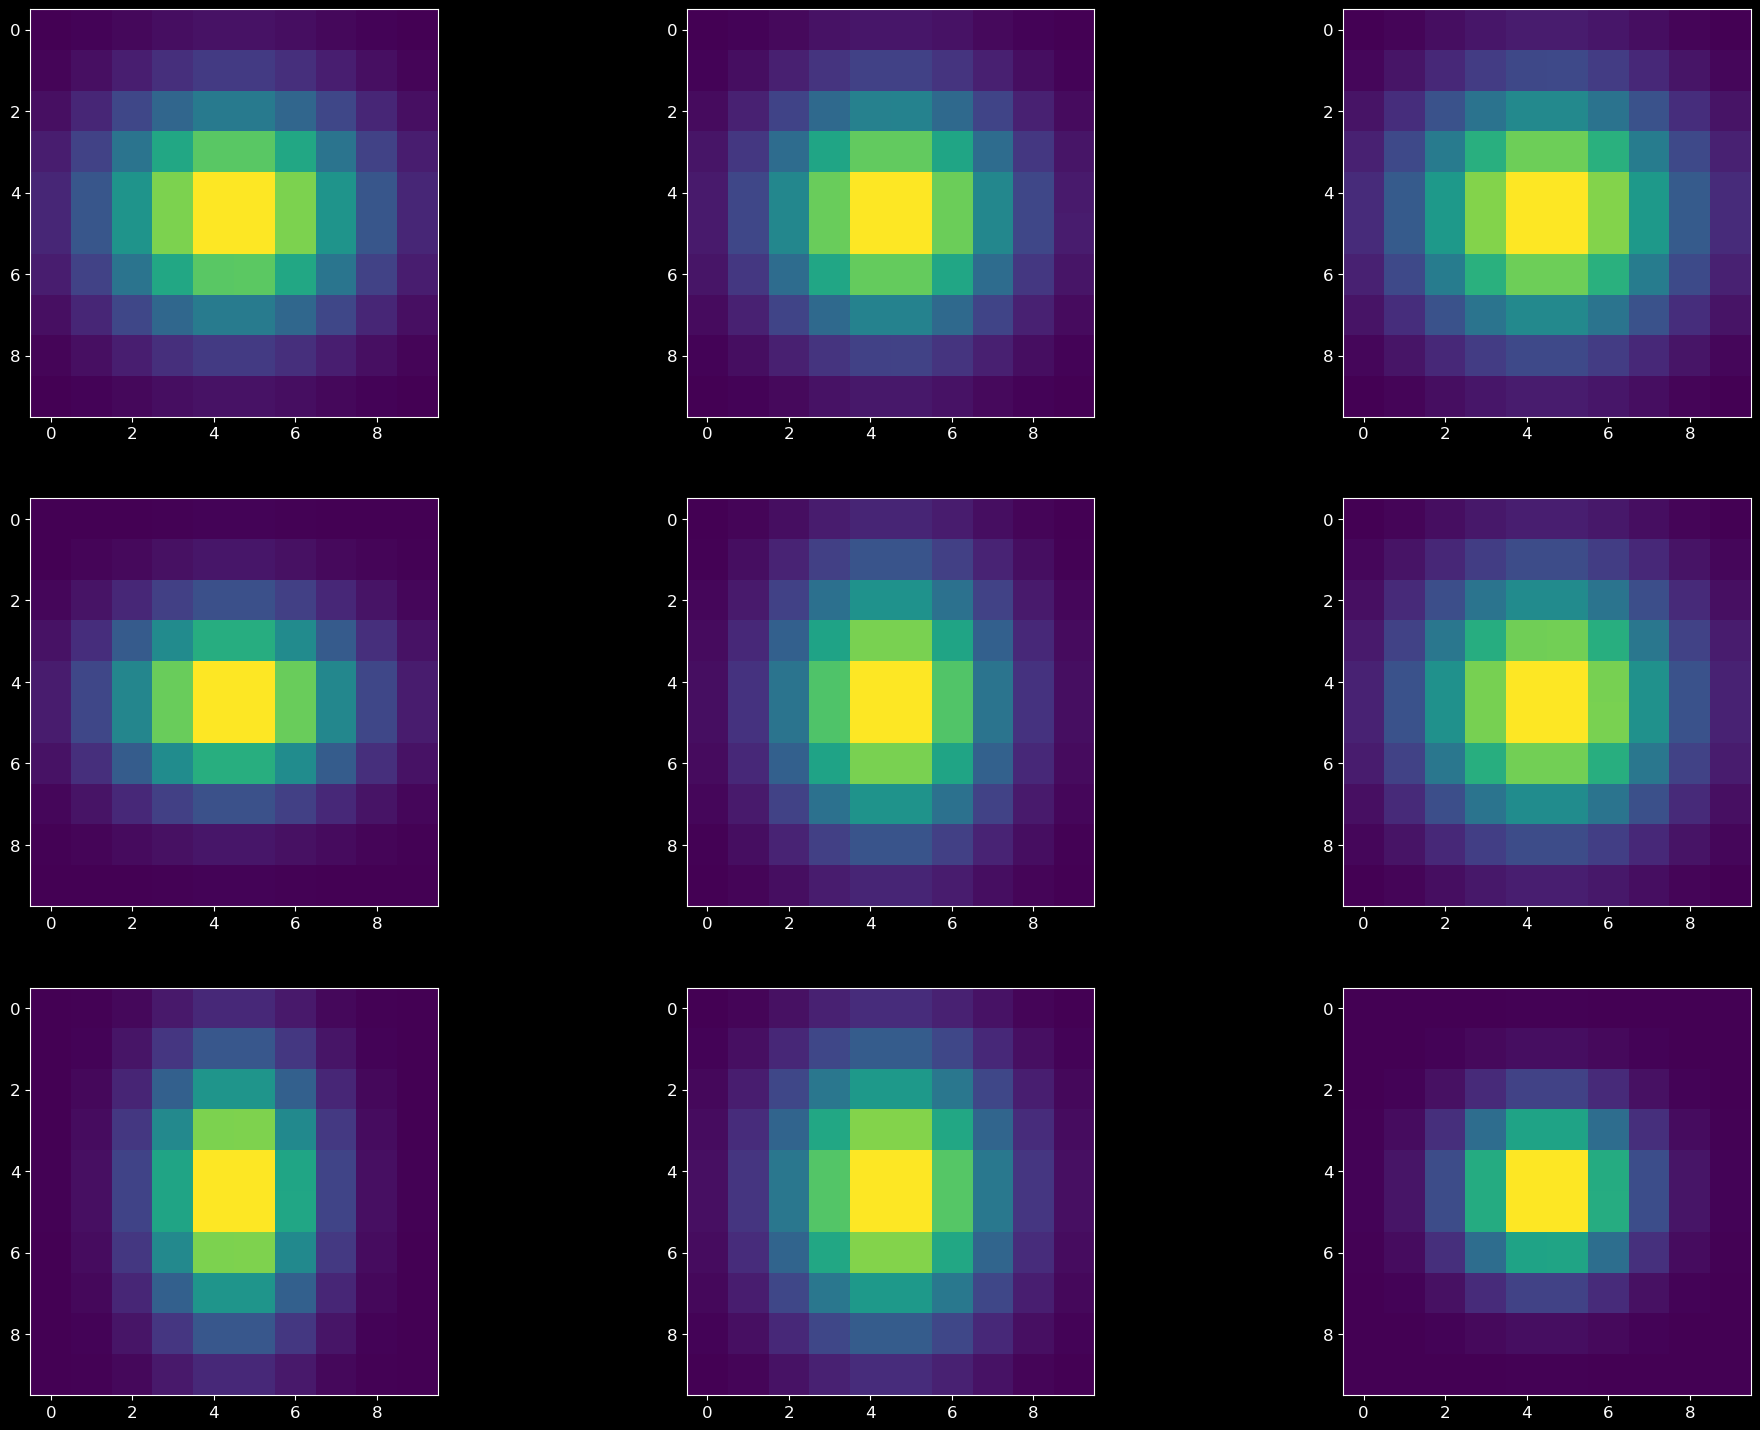

In [4]:
nrows = 3                                                                                                                                                                
ncols = 3                                                                                                                                                                
fig, axs = plt.subplots(nrows, ncols, figsize=(24,18))                                                                                                                   
for i in range(nrows):                                                                                                                                                   
    for j in range(ncols):                                                                                                                                               
        test_index = int(np.random.uniform(0,N))                                                                                                                       
        axs[i,j].imshow(gaussians_initial[test_index])


## Recurrent Inference Machine

In [5]:
# Create training, validation, and test sets
train_percentage = 0.7
valid_percentage = 0.9
test_percentage = 1.0
len_X = len(gaussians_initial)
# Training
X_train = gaussians_initial[:int(train_percentage*len_X)]
Y_train = gaussians_final[:int(train_percentage*len_X)]
A_train = powerlaw_conv[:int(train_percentage*len_X)]
N_train = noise[:int(train_percentage*len_X)]
#Validation
X_valid = gaussians_initial[int(train_percentage*len_X):int(valid_percentage*len_X)]
Y_valid = gaussians_final[int(train_percentage*len_X):int(valid_percentage*len_X)]
A_valid = powerlaw_conv[int(train_percentage*len_X):int(valid_percentage*len_X)]
N_valid = noise[int(train_percentage*len_X):int(valid_percentage*len_X)]
#Test
X_test = gaussians_initial[int(valid_percentage*len_X):]
Y_test = gaussians_final[int(valid_percentage*len_X):]
A_test = powerlaw_conv[int(valid_percentage*len_X):]
N_test = noise[int(valid_percentage*len_X):]

In [6]:
# Initiate RIM architecture to use. We are using the standard RIM archtecture defined in `rim_model.py` as `RIM_Model_1D`.
rim_architecture = RIM_Model_2D(conv_filters=8, kernel_size=3, rnn_units=[128, 128])
# Load model and define hyper parameters
epochs = 20  # Number of  epochs
batch_size = 8  # Batch size
learning_rate = 1e-2  # Initial learning rate
time_steps = 10  # Time steps
dimensions = 2  # Dimensions of the problem
learning_rate_function  = 'step'  # Type of learning rate function (options are: step, exponential, or linear)
model = RIM(rim_model=rim_architecture, gradient=calc_grad_standard_2D, input_size=n, dimensions=dimensions, t_steps=time_steps, 
            learning_rate=learning_rate, learning_rate_function=learning_rate_function)

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, A_train, N_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(2)
# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid, A_valid, N_valid))
val_dataset = val_dataset.batch(batch_size, drop_remainder=True)
val_dataset = val_dataset.prefetch(2)

In [7]:
# Fit model
ysol_valid, training_loss, valid_loss, learning_rates = model.fit(batch_size, epochs, train_dataset, val_dataset)

Training epoch: 1::  Completion: 0.00%  ETA 01:27:10  loss: 7.322E-01  MSE: 7.325E-01
Training epoch: 1::  Completion: 5.71%  ETA 00:04:14  loss: 2.889E-01  MSE: 2.056E+00
Training epoch: 1::  Completion: 11.43%  ETA 00:04:33  loss: 2.555E-01  MSE: 1.195E+00
Training epoch: 1::  Completion: 17.14%  ETA 00:05:04  loss: 2.024E-01  MSE: 8.583E-01
Training epoch: 1::  Completion: 22.86%  ETA 00:04:54  loss: 1.937E-01  MSE: 7.057E-01
Training epoch: 1::  Completion: 28.57%  ETA 00:03:24  loss: 2.007E-01  MSE: 6.019E-01
Training epoch: 1::  Completion: 34.29%  ETA 00:03:39  loss: 1.946E-01  MSE: 5.325E-01
Training epoch: 1::  Completion: 40.00%  ETA 00:02:35  loss: 2.027E-01  MSE: 4.818E-01
Training epoch: 1::  Completion: 45.71%  ETA 00:02:25  loss: 2.015E-01  MSE: 4.446E-01
Training epoch: 1::  Completion: 51.43%  ETA 00:03:19  loss: 2.003E-01  MSE: 4.157E-01
Training epoch: 1::  Completion: 57.14%  ETA 00:01:58  loss: 2.041E-01  MSE: 3.924E-01
Training epoch: 1::  Completion: 62.86%  ETA 

In [ ]:
plt.plot(np.linspace(0, epochs, epochs), training_loss, label='training')
plt.plot(np.linspace(0, epochs, epochs), valid_loss, label='validation')
plt.legend()

In [ ]:
#test_dataset = (Y_test, A_test)#tf.data.Dataset.from_tensor_slices((Y_test, A_test))
test_dataset = tf.data.Dataset.from_tensor_slices((Y_test, A_test, N_test))
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
ysol = model(test_dataset)

In [ ]:
#ysol = [val.numpy() for val in ysol[0]]
ysol_list = []
for val in ysol:
    ysol_ = [val.numpy()[0] for val in val]
    ysol_list.append(ysol_)


In [ ]:
nrows = 3                                                                                                                                                                
ncols = 3                                                                                                                                                                
fig, axs = plt.subplots(nrows, ncols, figsize=(24,18))                                                                                                                   
for i in range(nrows):   
    test_index = int(np.random.uniform(0,8))                                                                                                                                                 
    axs[i,0].imshow(gaussians_final[test_index])
    axs[i,1].imshow(gaussians_initial[test_index])
    axs[i,2].imshow(ysol_list[0][test_index])
for ax, col in zip(axs[0], ['Final', 'Initial', 'Reconstruction']):
    ax.set_title(col)

### 